In [1]:
import nltk
nltk.download('stopwords',download_dir='./data/nltk')
nltk.data.path.append('./data/nltk')
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from importlib.metadata import version
import summa
import tensorflow

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to ./data/nltk...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.2.0


# Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)<br>
아래의 코드로 데이터를 다운로드할 수 있어요.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='utf-8')

In [4]:
data.sample(10)

,headlines,text
25411,Air India paintings to be given to culture min...,Paintings in possession of Air India won't be ...
35400,"Kathua, Unnao cases darkest hour: Ex-bureaucra...",Slamming the government over the Unnao and Kat...
31567,BJP leader tweets pic of inverse flag at AAP m...,BJP leader Harish Khurana on Wednesday posted ...
19860,Andhra govt plans snake god ritual after 100 s...,The Andhra Pradesh government plans to conduct...
30730,"Big B named most engaging B'wood actor on FB, ...",Amitabh Bachchan took to Twitter to share a su...
17421,MP varsity launches 'adarsh bahu' course to 'e...,Barkatullah University in Madhya Pradesh's Bho...
92935,Facebook owns world's top 4 most downloaded apps,Mark Zuckerberg Co-founded social media giant ...
73443,The Great Gatsby's mansion on sale for over â...,The mansion that inspired The Great Gatsby by ...
7668,NASA probe reaches asteroid to collect samples...,NASA's OSIRIS-REx has arrived at asteroid Benn...
28580,Man paralysed after 2-litre poop cuts off bloo...,An Australian man was left temporarily paralys...


# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

## 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# 데이터 프레임에서 중복값 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# 데이터 프레임에 null값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 텍스트 정규화와 불용어 제거

In [8]:
# 같은의미 인데도 다른 표현으로 쓰며 단어처럼 간주되는 것 제거 (텍스트 정규화)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
# 일반적으로 텍스트에 자주등장하지만 자연어 처리 할 때 실질적으로 별 도움이 되지 않는 단어들(불용어)
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['text_new'] = clean_text
data['headlines_new'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines        0
text             0
text_new         0
headlines_new    0
dtype: int64

## 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


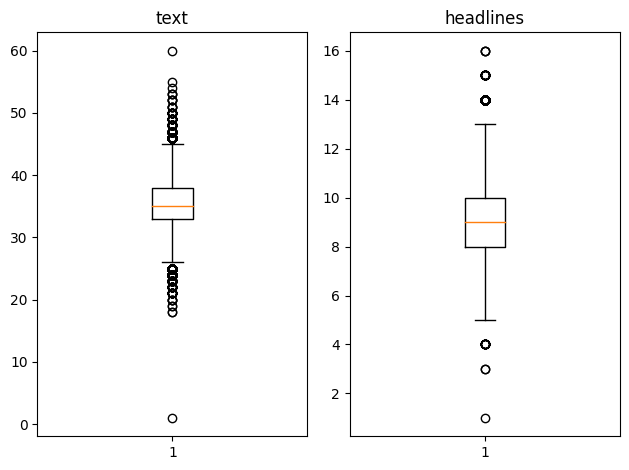

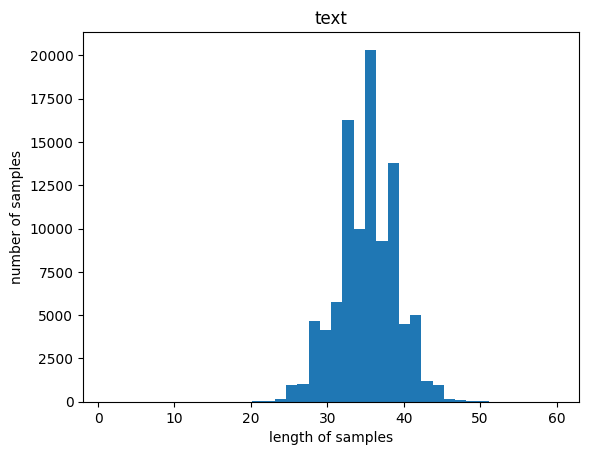

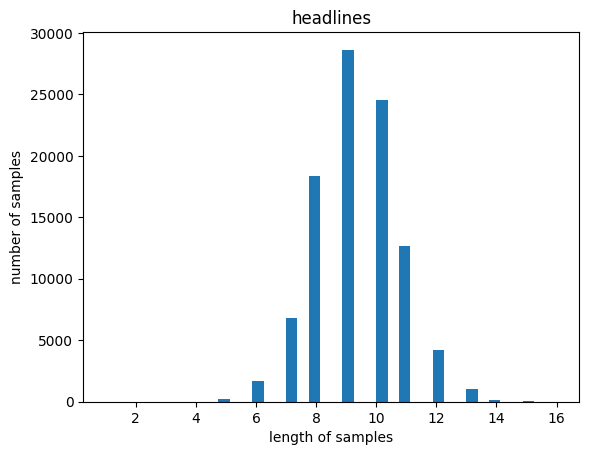

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text_new']]
summary_len = [len(s.split()) for s in data['headlines_new']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 45
summary_max_len = 12

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text_new'])
below_threshold_len(summary_max_len,  data['headlines_new'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [20]:
data = data[data['text_new'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines_new'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


## 시작 토큰과 종료 토큰 추가하기

In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines_new'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines_new'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,text_new,headlines_new,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [22]:
encoder_input = np.array(data['text_new']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[41487 21606 94993 ... 27144 85749 70091]


In [24]:
# 잘 섞인 샘플 만들기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
# 20% 테스트 데이터 만들기 위해 index위치 값 계산
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69012
등장 빈도가 6번 이하인 희귀 단어의 수: 46985
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22027
단어 집합에서 희귀 단어의 비율: 68.0823624876833
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5105854274212804


In [29]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 21,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[26, 894, 46, 14, 2515, 4813, 69, 2210, 21, 1176, 16551, 18, 5550, 62, 1843, 2295, 8, 874, 34, 80, 1138, 839, 1, 584, 246, 804, 453, 205, 3129, 450, 409, 27, 1635, 61, 155, 1343, 590, 243, 177, 874], [1589, 97, 20, 57, 68, 352, 8, 3902, 2456, 530, 323, 2124, 5770, 4586, 126, 1238, 61, 8, 249, 20, 1664, 530, 323, 1115, 699, 7745, 126, 687, 10, 6441, 1337, 136, 323, 442, 638, 5770, 20, 68], [27, 11160, 66, 3549, 3336, 13648, 2125, 3212, 993, 66, 451, 7, 1557, 261, 2007, 5365, 401, 365, 849, 261, 3549, 3336, 701, 3696, 1900, 6509, 4518, 1040, 533]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29908
등장 빈도가 5번 이하인 희귀 단어의 수: 19528
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10380
단어 집합에서 희귀 단어의 비율: 65.29356693861175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.69796461391101


In [33]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 425, 8713, 50, 5, 9465, 4207, 4, 23, 595], [1, 197, 261, 825, 317, 2549, 2415, 319, 123, 137, 341, 23], [1, 54, 8714, 75, 241, 7152, 3651, 13, 204], [1, 73, 10, 1766, 1266, 4, 553, 704, 2706, 409], [1, 1401, 1877, 1624, 124, 7, 1898, 28, 45, 5599]]
target
decoder  [[425, 8713, 50, 5, 9465, 4207, 4, 23, 595, 2], [197, 261, 825, 317, 2549, 2415, 319, 123, 137, 341, 23, 2], [54, 8714, 75, 241, 7152, 3651, 13, 204, 2], [73, 10, 1766, 1266, 4, 553, 704, 2706, 409, 2], [1401, 1877, 1624, 124, 7, 1898, 28, 45, 5599, 2]]


In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [35]:
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## 패딩하기

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델설계하기

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

2022-11-01 20:38:57.409510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 20:38:57.854760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9894 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:41:00.0, compute capability: 6.1


In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

2022-11-01 20:39:22.327278: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-01 20:39:25.597072: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1080 Ti" frequency: 1683 num_cores: 28 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2883584 shared_memory_size_per_multiprocessor: 98304 memory_size: 10374807552 bandwidth: 484440000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-11-01 20:39:26.302656: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8600


303/303 [==============================] - ETA: 0s - loss: 5.6243

2022-11-01 20:39:46.502281: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1080 Ti" frequency: 1683 num_cores: 28 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2883584 shared_memory_size_per_multiprocessor: 98304 memory_size: 10374807552 bandwidth: 484440000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


303/303 [==============================] - 26s 73ms/step - loss: 5.6243 - val_loss: 5.1823
Epoch 2/50
303/303 [==============================] - 21s 71ms/step - loss: 5.0349 - val_loss: 4.8047
Epoch 3/50
303/303 [==============================] - 21s 71ms/step - loss: 4.6890 - val_loss: 4.5394
Epoch 4/50
303/303 [==============================] - 22s 74ms/step - loss: 4.4201 - val_loss: 4.3507
Epoch 5/50
303/303 [==============================] - 22s 71ms/step - loss: 4.2143 - val_loss: 4.2091
Epoch 6/50
303/303 [==============================] - 25s 81ms/step - loss: 4.0504 - val_loss: 4.1078
Epoch 7/50
303/303 [==============================] - 29s 95ms/step - loss: 3.9065 - val_loss: 4.0211
Epoch 8/50
303/303 [==============================] - 25s 83ms/step - loss: 3.7826 - val_loss: 3.9601
Epoch 9/50
303/303 [==============================] - 25s 83ms/step - loss: 3.6726 - val_loss: 3.8999
Epoch 10/50
303/303 [==============================] - 25s 81ms/step - loss: 3.5743 - val_los

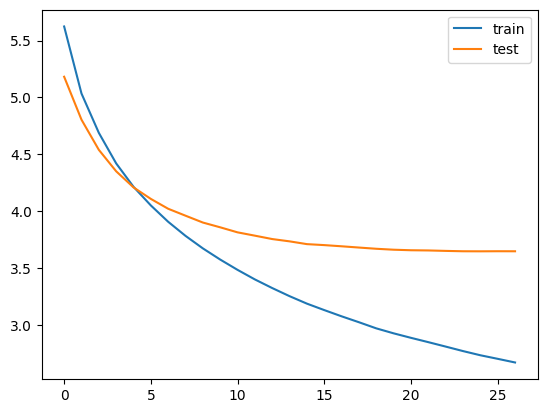

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : ministry urban development proposed bill provides life sentence death penalty act sabotage intent cause death metro premises across india metro rail bill provides fine drunk commuters four year jail term carrying guns inside metro 
실제 요약 : bill proposes death penalty for 


2022-11-01 20:53:10.495848: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1080 Ti" frequency: 1683 num_cores: 28 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2883584 shared_memory_size_per_multiprocessor: 98304 memory_size: 10374807552 bandwidth: 484440000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


예측 요약 :  compensation for victims of martyred in iraq


원문 : following australia th consecutive away odi loss indian spinner harbhajan singh said current australian team like sri lankan team playing yellow jersey think australia anyone finch warner steve smith take team forward added earlier harbhajan asked michael clarke come retirement rescue australia 
실제 요약 : harbhajan calls australia cricket team sri lanka in yellow 
예측 요약 :  australia australia australia australia series win aus coach


원문 : flipkart internet marketplace arm flipkart india reduced losses crore financial year compared crore year ago period decrease attributed reduction logistics storage charges filings revealed however revenue grew crore period crore fiscal 
실제 요약 : flipkart internet loss reduced by to cr in fy 
예측 요약 :  flipkart invests crore in flipkart walmart


원문 : actress alia bhatt referring earnings baahubali jokingly said baahubali think right talk box office added baahubali everybody wants keep quiet goo

예측 요약 :  srk to make comeback in film on srk reports


원문 : least nine people killed others injured afghan border forces opened fire pakistani security personnel guarding census team balochistan area notably afghan border forces creating hurdles conduct census divided villages pakistani side border 
실제 요약 : afghan firing on pakistan census team kills injures 
예측 요약 :  killed injured in blast in afghanistan


원문 : pakistan coach mickey arthur handed official warning one demerit point breaching icc code conduct third day play first south africa pakistan test arthur entered tv umpire room showed dissent decision given favour dean elgar room 
실제 요약 : pak coach warned for showing dissent at umpire decision 
예측 요약 :  pak pacer fined for making finger to pak


원문 : referring defence minister nirmala sitharaman speech rafale deal lok sabha pm narendra modi saturday said congratulate defence minister nirmala sitharaman showed people india real face country compromise national security politics 

예측 요약 :  china overtakes us as world biggest stock


원문 : asked difficulties faced building technology team makemytrip ceo deep kalra said gone many become joke said would start co founder would skills would 
실제 요약 : we have gone through so many it is joke makemytrip ceo 
예측 요약 :  we have open to open ceo of makemytrip ceo


원문 : karan johar announced upcoming production war drama starring varun dhawan directed shashank khaitan third time trio working together sharma ki dulhania badrinath ki dulhania remaining cast yet announced film scheduled diwali release 
실제 요약 : varun to star in johar and war drama 
예측 요약 :  karan johar to appear in koffee with karan reports


원문 : talking working conditions amazon centres employee allegedly said management regard us crucial success treat us like disposable parts employee also said like factory workers assembly line essentially extensions machine work hard make amazon run employee added 
실제 요약 : management treats us like parts amazon employee 
예측 

# Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [48]:
from summa import summarizer
from summa import keywords

In [52]:
org_input = np.array(data['text'])
org_headline = np.array(data['headlines'])

org_input = org_input[indices]
org_headline = org_headline[indices]

org_input_test = org_input[-n_of_val:]
org_headline_test = org_headline[-n_of_val:]

In [70]:
for i in range(50, 100):
    print("원문 :", org_input_test[i])
    print("실제 요약 :", org_headline_test[i])
    print("summa요약 :", summarizer.summarize(org_input_test[i],ratio=0.5,words=20))
    print("\n")

원문 : The Ministry of Urban Development has proposed a bill that provides for a life sentence or a death penalty for âany act of sabotage with the intent to cause deathâ in metro premises across India. The Metro Rail Bill 2017 further provides a fine of â¹5,000 for drunk commuters and a four-year jail term for carrying guns inside the metro.
실제 요약 : Bill proposes death penalty for sabotaging metros
summa요약 : The Ministry of Urban Development has proposed a bill that provides for a life sentence or a death penalty for âany act of sabotage with the intent to cause deathâ in metro premises across India.


원문 : Following Australia's 11th consecutive away ODI loss, Indian spinner Harbhajan Singh said the current Australian team is like the Sri Lankan team playing in yellow jersey. "I don't think in [Australia] anyone other than Finch or Warner or...Steve Smith can take the team forward," he added. Earlier, Harbhajan had asked Michael Clarke to come out of retirement and rescue Austr

# Step 6. 추상적 요약과 추출적 요약 비교

In [71]:
for i in [50,60,70]:
    print("원문 :", org_input_test[i])
    print("실제 요약 :", org_headline_test[i])
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 요약 :", summarizer.summarize(org_input_test[i],ratio=0.5,words=20))
    print("\n")

원문 : The Ministry of Urban Development has proposed a bill that provides for a life sentence or a death penalty for âany act of sabotage with the intent to cause deathâ in metro premises across India. The Metro Rail Bill 2017 further provides a fine of â¹5,000 for drunk commuters and a four-year jail term for carrying guns inside the metro.
실제 요약 : Bill proposes death penalty for sabotaging metros
추상적 요약 :  compensation for victims of martyred in iraq
추출적 요약 : The Ministry of Urban Development has proposed a bill that provides for a life sentence or a death penalty for âany act of sabotage with the intent to cause deathâ in metro premises across India.


원문 : A Railway Protection Force constable saved an elderly couple who was on the railway tracks of a Mumbai station on Sunday. The couple was crossing the tracks when a train began approaching them at a fast pace, the RPF said. The constable "rushed towards them and pulled them to safety seconds before the local train passed t